In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

In [2]:
# Suppress ConvergenceWarning 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [10]:
class PriceEnvironment:
    """Simulated demand function for a single product."""
    def __init__(self, noise_std=0.02):
        self.noise_std = noise_std

    # def demand_function(self, price):
    #     """Unknown nonlinear demand function (ground truth)."""
    #     return np.clip(1.0 - 0.3 * price + 0.1 * np.sin(3 * price), 0, 1)

    def demand_function(self, price):
        """Unknown nonlinear demand function (ground truth)."""
        return np.clip(1.0 - 0.3 * price + 0.1 * np.sin(3 * price) + 0.05 * np.cos(5 * price), 0, 1) * 10

    def get_revenue(self, price):
        """Returns observed revenue (price * demand) with noise."""
        demand = self.demand_function(price)
        noise = np.random.normal(0, self.noise_std)
        return price * (demand + noise)

In [4]:
class GPUCBPriceAgent:
    def __init__(self, bounds, beta_func, kernel=None):
        self.bounds = bounds
        self.beta_func = beta_func  # function of t
        self.X = np.empty((0, 1))
        self.y = np.empty((0,))
        if kernel is None:
            kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5)
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, normalize_y=True)

    def select_price(self, t):
        """Selects next price using GP-UCB."""
        prices = np.linspace(*self.bounds, 1000).reshape(-1, 1)
        if len(self.X) > 0:
            self.gp.fit(self.X, self.y)
            mu, sigma = self.gp.predict(prices, return_std=True)
            beta_t = self.beta_func(t)
            ucb = mu + np.sqrt(beta_t) * sigma
            return prices[np.argmax(ucb)][0]
        else:
            return np.random.uniform(*self.bounds)

    def update(self, price, revenue):
        """Update observed data."""
        self.X = np.vstack((self.X, [[price]]))
        self.y = np.append(self.y, revenue)

In [5]:
def run_simulation(T=100, price_bounds=(0.1, 2.0)):
    env = PriceEnvironment()
    beta_func = lambda t: 2 * np.log(t + 1)  # e.g., Srinivas et al. (2010)
    agent = GPUCBPriceAgent(bounds=price_bounds, beta_func=beta_func)

    prices, rewards, regrets = [], [], []
    optimal_price = max(
        np.linspace(*price_bounds, 1000), 
        key=lambda p: p * env.demand_function(p)
    )
    optimal_revenue = optimal_price * env.demand_function(optimal_price)

    for t in range(1, T + 1):
        price = agent.select_price(t)
        reward = env.get_revenue(price)
        regret = optimal_revenue - reward

        agent.update(price, reward)

        prices.append(price)
        rewards.append(reward)
        regrets.append(regret)

    return prices, rewards, regrets, optimal_price

In [11]:
max(
    np.linspace(*(0.1, 2.0), 1000), 
    key=lambda p: p * PriceEnvironment().demand_function(p)
)

np.float64(1.2221221221221221)

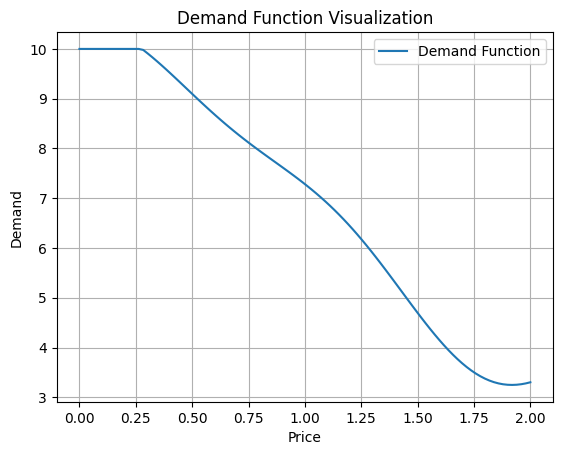

In [12]:
# Plot demand function
prices = np.linspace(0, 2, 100)
demands = PriceEnvironment().demand_function(prices)
plt.plot(prices, demands, label='Demand Function')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand Function Visualization')
plt.legend()
plt.grid()
plt.show()

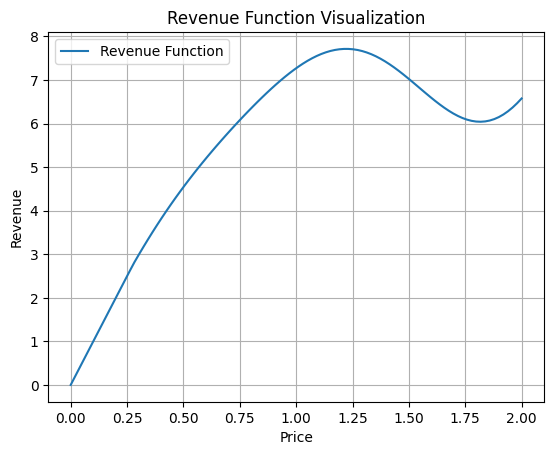

In [18]:
prices = np.linspace(0, 2, 100)
demands = PriceEnvironment().get_revenue(prices)
plt.plot(prices, demands, label='Revenue Function')
plt.xlabel('Price')
plt.ylabel('Revenue')
plt.title('Revenue Function Visualization')
plt.legend()
plt.grid()
plt.show()

In [15]:
prices, rewards, regrets, opt_price = run_simulation(T=1000)
cum_regret = np.cumsum(regrets)

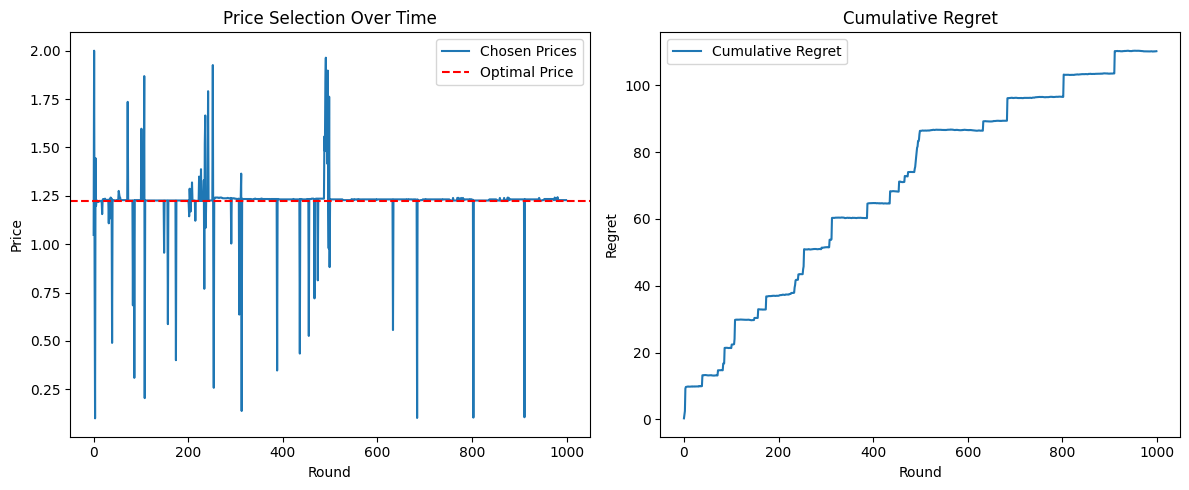

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(prices, label="Chosen Prices")
plt.axhline(opt_price, color='r', linestyle='--', label="Optimal Price")
plt.title("Price Selection Over Time")
plt.xlabel("Round")
plt.ylabel("Price")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cum_regret, label="Cumulative Regret")
plt.title("Cumulative Regret")
plt.xlabel("Round")
plt.ylabel("Regret")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()
    
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1


In [27]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

In [28]:
n_customers = 100
T = 1000
min_price, max_price = 10, 20
n_customers = 100
cost = 10

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/20
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

agent = GPUCBAgent(T)
np.random.seed(2)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, 1000)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

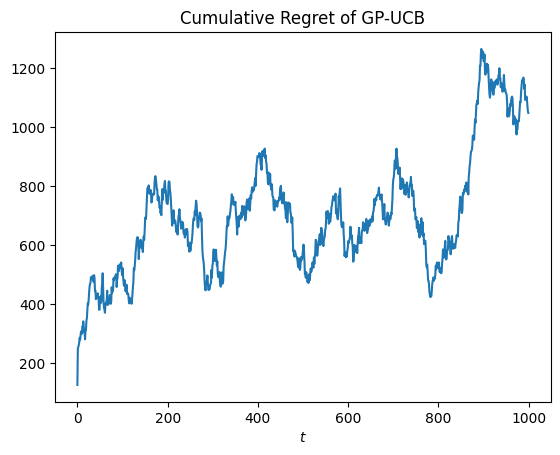

In [25]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show()